# Fitting Coupled GMMs

Several papers have recently proposed a Wasserstein-like distance measure between Gaussian mixture models {cite}`chen:16,chen:19a,chen:20,delon:20`. This idea rests on two facts:

1. there is an analytic solution for the Wasserstein distance between two Gaussians, and
2. if one limits the set of allowed couplings between GMMs to the space of Gaussian mixtures, one can define a Wasserstein-like distance between a pair of GMMs using the Wasserstein distance between their components.

In {cite}`delon:20`, the distance $\mathrm{MW_2}$ between two GMMs, $\mu_0$ and $\mu_1$, is defined as follows:

$$\mathrm{MW_2}^2(\mu_0, \mu_1) = \inf_{\gamma\in \Pi(\mu_0, \mu_1) \cap GMM_{2d}(\infty)} \int_{\mathbb{R}^d\times \mathbb{R}^d} \|y_0-y_1\|^2 d\gamma(y_0, y_1)$$

where $\Pi(\mu_0, \mu_1)$ is the set of probability measures on $(\mathbb{R}^d)^2$ having $\mu_0$ and $\mu_1$ as marginals, and $\mathrm{GMM_d}(K)$ is the set of Gaussian mixtures in $\mathbb{R}^d$ with less than $K$ components (see Eq. 4.1 in paper).

One appealing thing about this distance is that it can be obtained by solving a simpler discrete OT problem,

$$\mathrm{MW_2}^2(\mu_0, \mu_1) = \min_{w \in \Pi(\pi_0, \pi_1)} \sum_{k,l} w_{kl} W_2^2(\mu_0^k, \mu_1^l)$$

where here $\Pi(\pi_0, \pi_1)$ is the set of $K_0\times K_1$ coupling matrices with marginals $\pi_0$ and $\pi_1$, and $W^2_2(\mu_0^k, \mu_1^l)$ is the {class}`~ott.geometry.costs.Bures` distance between two Gaussians, component $k$ of $\mu_0$ and component $l$ of $\mu_1$ (see Eq. 4.4 in paper).

We can obtain a regularized solution to this minimization problem by using the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm on a `~ott.geometry.pointcloud.PointCloud` geometry instantiated with a {class}`~ott.geometry.costs.Bures` cost function.

{cite}`delon:20` suggest using $\mathrm{MW_2}$ to approximate an optimal transport *map* between two arbitrary point clouds, by fitting a {class}`~ott.tools.gaussian_mixture.gaussian_mixture.GaussianMixture` model to each {class}`~ott.geometry.pointcloud.PointCloud` that minimizes the $\mathrm{MW_2}$ distance between the fitted GMMs (see section 6 in paper), rather than computing these GMMs independently using the EM algorithm. The approach scales well to large point clouds since the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm is applied only to the mixture components rather than to individual points. The resulting couplings are easy to interpret since they involve relatively small numbers of components, and the transport maps are mixtures of piecewise linear maps.

We demonstrate this approach on synthetic data.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from ott.tools.gaussian_mixture import (
    fit_gmm,
    fit_gmm_pair,
    gaussian_mixture,
    gaussian_mixture_pair,
    probabilities,
)

In [3]:
def get_cov_ellipse(mean, cov, n_sds=2, **kwargs):
    """Get a matplotlib Ellipse patch for a given mean and covariance.

    Adapted from: https://scipython.com/book/chapter-7-matplotlib/examples/bmi-data-with-confidence-ellipses/
    """
    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = jnp.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by
    vx, vy = eigvecs[:, 0][0], eigvecs[:, 0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * n_sds * np.sqrt(eigvals)
    return matplotlib.patches.Ellipse(
        xy=mean, width=width, height=height, angle=np.degrees(theta), **kwargs
    )

## Generate synthetic data

Construct two ground-truth {class}`~ott.tools.gaussian_mixture.gaussian_mixture.GaussianMixture` models to generate some samples.

The two GMMs have small differences in their means, covariances, and in their weights.

In [9]:
rng = jax.random.PRNGKey(0)
mean_generator0 = jnp.array([[2.0, -1.0], [-2.0, 0.0], [4.0, 3.0]])
cov_generator0 = 3.0 * jnp.array(
    [
        [[0.2, 0.0], [0.0, 0.1]],
        [[0.6, 0.0], [0.0, 0.3]],
        [[0.5, -0.4], [-0.4, 0.5]],
    ]
)
weights_generator0 = jnp.array([0.2, 0.2, 0.6])

gmm_generator0 = (
    gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(
        mean=mean_generator0,
        cov=cov_generator0,
        component_weights=weights_generator0,
    )
)


def rot(m, theta):
    # left multiply m by a theta degree rotation matrix
    theta_rad = theta * 2.0 * np.pi / 360.0
    m_rot = jnp.array(
        [
            [jnp.cos(theta_rad), -jnp.sin(theta_rad)],
            [jnp.sin(theta_rad), jnp.cos(theta_rad)],
        ]
    )
    return jnp.matmul(m_rot, m)


# shift the means to the right by varying amounts
mean_generator1 = mean_generator0 + jnp.array(
    [[1.0, -0.5], [-1.0, -1.0], [-1.0, 0.0]]
)
# rotate the covariances a bit
cov_generator1 = jnp.stack(
    [
        rot(cov_generator0[0, :], 5),
        rot(cov_generator0[1, :], -5),
        rot(cov_generator0[2, :], -10),
    ],
    axis=0,
)
weights_generator1 = jnp.array([0.4, 0.4, 0.2])

gmm_generator1 = (
    gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(
        mean=mean_generator1,
        cov=cov_generator1,
        component_weights=weights_generator1,
    )
)

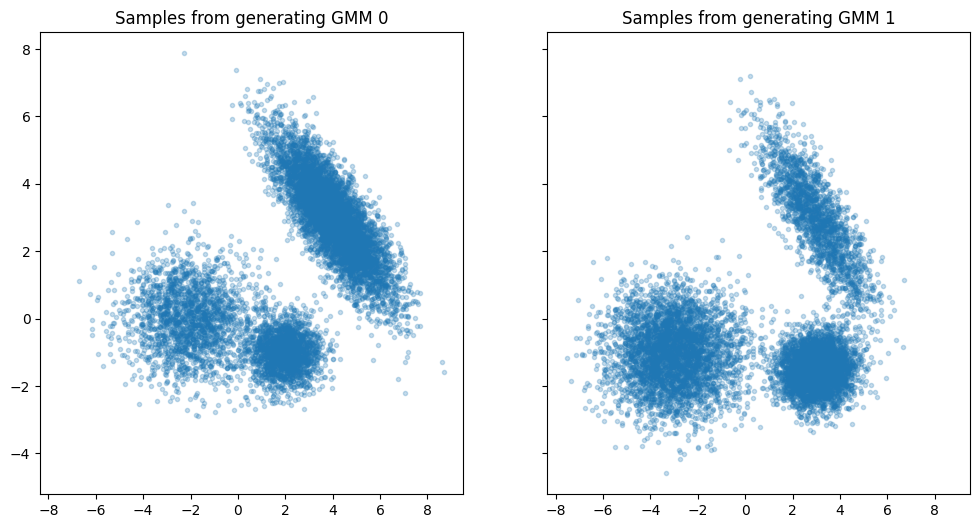

In [12]:
N = 10_000
rng, rng1, rng2 = jax.random.split(rng, num=3)
samples_gmm0 = gmm_generator0.sample(rng=rng1, size=N)
samples_gmm1 = gmm_generator1.sample(rng=rng2, size=N)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))
axes[0].scatter(samples_gmm0[:, 0], samples_gmm0[:, 1], marker=".", alpha=0.25)
axes[0].set_title("Samples from generating GMM 0")
axes[1].scatter(samples_gmm1[:, 0], samples_gmm1[:, 1], marker=".", alpha=0.25)
axes[1].set_title("Samples from generating GMM 1")
plt.show()

## Fit a pair of coupled GMMs

We now pool the two sets of samples and fit a single GMM to the combined samples. This GMM is simply used to initialize our iterates, towards the goal of computing the two GMMs we seek to compute for each of the point clouds.


In [21]:
samples = jnp.concatenate([samples_gmm0, samples_gmm1])
rng, rng1 = jax.random.split(rng)
gmm_init = fit_gmm.initialize(
    rng=rng1, points=samples, point_weights=None, n_components=3, verbose=True
)
pooled_gmm = fit_gmm.fit_model_em(
    gmm=gmm_init, points=samples, point_weights=None, steps=20
)

We now use EM to fit a GMM to each set of samples while penalizing the distance between the pair of GMMs


In [22]:
%%time
# regularization weight for the Sinkhorn algorithm
epsilon = 0.01
# weight for the MW2 distance penalty between the GMMs
weight_transport = 0.01
pair_init = gaussian_mixture_pair.GaussianMixturePair(
    gmm0=pooled_gmm, gmm1=pooled_gmm, epsilon=epsilon, tau=1.0
)

fit_model_em_fn = fit_gmm_pair.get_fit_model_em_fn(
    weight_transport=weight_transport, jit=True
)

pair, loss = fit_model_em_fn(
    pair=pair_init,
    points0=samples_gmm0,
    points1=samples_gmm1,
    point_weights0=None,
    point_weights1=None,
    em_steps=30,
    m_steps=20,
    verbose=True,
)

  0 -3.872 -3.894 transport:0.011 objective:-7.766
  1 -3.848 -3.867 transport:0.026 objective:-7.715
  2 -3.827 -3.844 transport:0.069 objective:-7.672
  3 -3.810 -3.823 transport:0.133 objective:-7.634
  4 -3.794 -3.805 transport:0.212 objective:-7.601
  5 -3.781 -3.788 transport:0.312 objective:-7.572
  6 -3.769 -3.772 transport:0.429 objective:-7.546
  7 -3.758 -3.758 transport:0.558 objective:-7.521
  8 -3.747 -3.745 transport:0.708 objective:-7.499
  9 -3.737 -3.733 transport:0.876 objective:-7.479
 10 -3.727 -3.721 transport:1.062 objective:-7.459
 11 -3.718 -3.711 transport:1.268 objective:-7.442
 12 -3.709 -3.701 transport:1.494 objective:-7.426
 13 -3.701 -3.693 transport:1.736 objective:-7.411
 14 -3.693 -3.685 transport:1.997 objective:-7.398
 15 -3.685 -3.678 transport:2.277 objective:-7.386
 16 -3.678 -3.672 transport:2.575 objective:-7.376
 17 -3.671 -3.667 transport:2.882 objective:-7.368
 18 -3.665 -3.663 transport:3.186 objective:-7.360
 19 -3.659 -3.660 transport:3.5

/var/folders/xv/6qz2dpps43777hjnwhj2c9qm0000gn/T/ipykernel_93311/1202321110.py:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


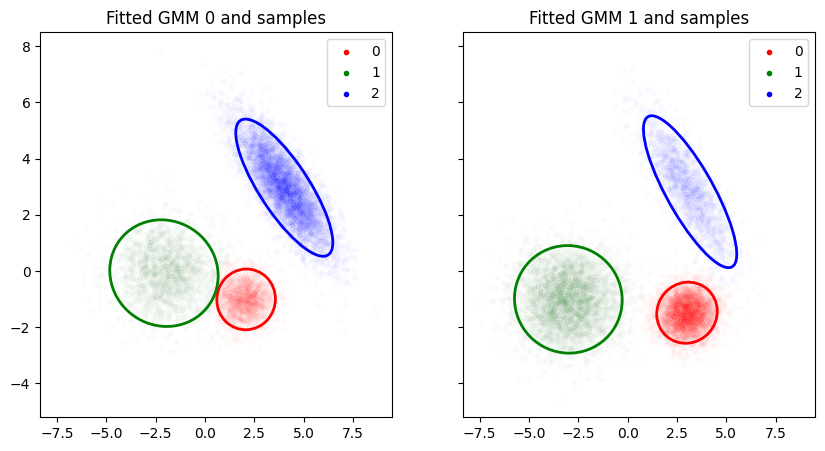

In [23]:
colors = ["red", "green", "blue"]
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
for i, (gmm, samples) in enumerate(
    [(pair.gmm0, samples_gmm0), (pair.gmm1, samples_gmm1)]
):
    assignment_prob = gmm.get_log_component_posterior(samples)
    assignment = jnp.argmax(assignment_prob, axis=-1)
    for j, component in enumerate(gmm.components()):
        subset = assignment == j
        axes[i].scatter(
            samples[subset, 0],
            samples[subset, 1],
            marker=".",
            alpha=0.01,
            color=colors[j],
            label=j,
        )
        ellipse = get_cov_ellipse(
            component.loc,
            component.covariance(),
            n_sds=2,
            ec=colors[j],
            fill=False,
            lw=2,
        )
        axes[i].add_artist(ellipse)
    legend = axes[i].legend()
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    axes[i].set_title(f"Fitted GMM {i} and samples")
plt.show()

In [24]:
print("Fitted GMM 0 masses", pair.gmm0.component_weights)
print("Fitted GMM 1 masses", pair.gmm1.component_weights)
print("Mass transfer, rows=source, columns=destination")
cost_matrix = pair.get_cost_matrix()
sinkhorn_output = pair.get_sinkhorn(cost_matrix=cost_matrix)
print(pair.get_normalized_sinkhorn_coupling(sinkhorn_output=sinkhorn_output))

Fitted GMM 0 masses [0.22632582 0.23542637 0.5382478 ]
Fitted GMM 1 masses [0.36791384 0.3672651  0.26482108]
Mass transfer, rows=source, columns=destination
[[0.22631681 0.         0.        ]
 [0.         0.2354198  0.        ]
 [0.2182516  0.         0.32001185]]


## Reweighting components

In the approach above, we can only change the weights of components by transferring mass between them. In some settings, allowing reweighting of components can lead to couplings that are easier to interpret. For example, in a biological application in which points correspond to a population of featurized representations of organisms, mixture components might capture subpopulations and a component reweighting might correspond to a prevalence change for the subpopulation.

We can generalize the approach above to allow component reweighting by using an *unbalanced* variant of $\mathrm{MW2}$ as our measure of distance between GMMs.

Recall that 

$$\mathrm{MW_2}^2(\mu_0, \mu_1) = \min_{w \in \Pi(\pi_0, \pi_1)} \sum_{k,l} w_{kl} W_2^2(\mu_0^k, \mu_1^l)$$

We use the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm to obtain a solution to a regularized version of the above minimization:

$$\mathrm{MW_2}^2(\mu_0, \mu_1) \approx \min_{w \in \Pi(\pi_0, \pi_1)} \sum_{k,l} w_{kl} W_2^2(\mu_0^k, \mu_1^l) + \epsilon \mathrm{KL}(w, a^T b)$$

## An unbalanced Wasserstein divergence for GMMs

We define $UW_2^2$, an unbalanced version of $\mathrm{MW_2}^2$, as follows:

$$UW_2^2(\mu_0, \mu_1) = \min_{w_{k,l} \geq 0} \sum_{k,l} w_{kl} W_2^2(\mu_0^k, \mu_1^l) + \rho \mathrm{KL}(w_{k \cdot}||\pi_0^k) + \rho \mathrm{KL}(w_{\cdot l}||\pi_1^l)$$

where $\mathrm{KL}(f||g)$ is the *generalized* KL divergence, 

$$\mathrm{KL}(f||g) = \sum_i f_i \log \frac{f_i}{g_i} - f_i + g_i$$

which does not assume that either $\sum f_i = 1$ or $\sum g_i = 1$.

As above, we add a regularization term to make the problem convex and solve with the unbalanced {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm.

## Interpreting the results

The coupling matrix $W$ we obtain from the unbalanced {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm has marginals that do not necessarily match the component weights of our GMMs, and it's worth looking in detail at an example to see how we might interpret this mismatch.

### Marginal mismatch

Suppose we have a pair of 2-component GMMs:

- $\mu_0$ with component weights $0.2$ and $0.8$, and
- $\mu_1$ with component weights $0.4$ and $0.6$.

Suppose the unbalanced Sinkhorn algorithm yields the coupling matrix

$$W = \begin{pmatrix}0.3 & 0.1\\0.2 & 0.4 \end{pmatrix}$$

The first row of the coupling matrix $W$ indicates that $0.4$ units of mass flow out of the first component of $\mu_0$, $0.3$ units to the first component of $\mu_1$ and $0.1$ to the second component of $\mu_1$. However, the first component of $\mu_0$ only has $0.2$ units of mass!

Similarly, the first column of $W$ indicates that $0.5$ units of mass flow into the first component of $\mu_1$, $0.3$ from the first component of $\mu_0$ and $0.2$ from the second component of $\mu_0$. Again, while $0.5$ units of mass flow in, the first component of $\mu_1$ only has $0.4$ units of mass.

### Reweighting points

Our interpretation is this: points from $\mu_0$ undergo two reweightings during transport, the first as they leave a component in $\mu_0$ and the second as they enter a component in $\mu_1$. Each of these reweightings has a cost that is reflected in the KL divergence between the marginals of the coupling matrix and the weights of the corresponding {class}`~ott.tools.gaussian_mixture.gaussian_mixture.GaussianMixture` components.

Suppose we transport a point with weight 1 from the first component of $\mu_0$ to the first component of $\mu_1$.

- We see from the coupling matrix that the first component of $\mu_0$ has mass $0.2$ but has an outflow of $0.4$. To achieve the indicated outflow, we double the weight of our point as it leaves the first component of $\mu_0$, so now our point has a weight of $2$.
- We see that the first component of $\mu_1$ has a mass of $0.4$ but an inflow of $0.5$. To achieve the indicated inflow, we need to decrease the weight of incoming points by a factor of $0.8$.

The net effect is that the weight of our point increases by a factor of $2 \times 0.8 = 1.6$

### Non-normalized couplings

One point that is worth emphasizing: in the unbalanced case, the coupling matrix we obtain from the Sinkhorn algorithm need not have a total mass of $1$! 

Let's look at the objective function in more detail to see why this might happen.

Recall that $UW_2^2$ penalizes mismatches between the marginals of the coupling matrix and the GMM component weights via the generalized KL divergence,

$$\mathrm{KL}(f||g) = \sum_i f_i \log \frac{f_i}{g_i} - f_i + g_i$$

In the divergence above, $f$ is a marginal of the coupling, which may not sum to $1$, and $g$ is the set of weights for a GMM and does sum to 1. Let $p_i = \frac{f_i}{\sum_i f_i} = \frac{f_i}{F}$ be the normalized marginal of the coupling. We have

$$\mathrm{KL}(f||g) = \sum_i F p_i \log \frac{F p_i}{g_i} - F p_i + g_i \\
= F \sum_i \left(p_i \log \frac{p_i}{g_i} + p_i \log F \right) - F + 1 \\
= F \sum_i p_i \log \frac{p_i}{g_i} + F \log F - F + 1 \\
= F \mathrm{KL}(p||g) + (F \log F - F + 1)$$

Thus, having an non-normalized coupling scales each KL divergence penalty by the total mass of the coupling, $F$, and adds a penalty of the form $F \log F - F + 1$.

In addition, the transport cost for the non-normalized coupling is simply the transport cost for the normalized coupling scaled by the same factor $F$.

The result is that the cost for an non-normalized coupling $W$ that sums to $F$ is $F$ times the cost for the *normalized* coupling $W/F$ plus $(\epsilon + 2\rho)(F \log F - F + 1)$.

For $F \geq 0$, the function $F \log F - F + 1$ is strictly convex, has a minimum of $0$ at $1$ and is $1$ at $0$ and $e$.

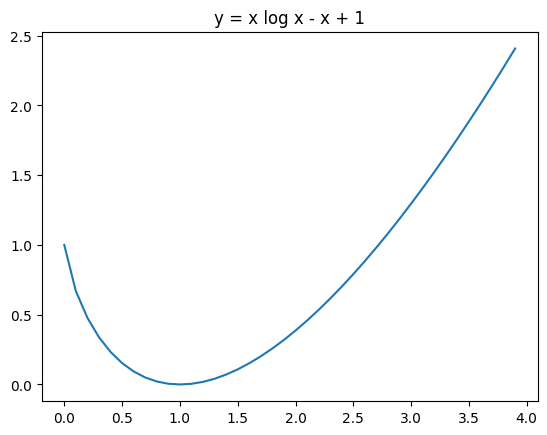

In [25]:
# @title x log x - x + 1  { display-mode: "form" }
x = np.arange(0, 4, 0.1)
y = x * jnp.log(x) - x + 1
y = y.at[0].set(1.0)
plt.plot(x, y)
plt.title("y = x log x - x + 1")
plt.show()

We should never get an $F$ larger than $1$, since such an $F$ will both increase the cost of the normalized coupling as well as introduce a positive penalty term. If we use the balanced {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm, we will always have $F = 1$. 

The case of $F \in (0, 1)$ can be interpreted to mean that all points are down-weighted for transport to reduce the overall cost. We can shift the transport and reweighting costs into the normalization penalty, $(\epsilon + 2 \rho)(F \log F - F + 1)$. 

The net effect of this flexibility in allocating costs to the normalization penalty term is to bound the total regularized cost to be less than or equal to $(\epsilon + 2 \rho)(F \log F - F + 1) <= (\epsilon + 2 \rho)$, something to consider in setting the various weights used in the overall optimization.

In [26]:
%%time
# here we use a larger transport weight because the transport cost is smaller
# (see discussion above)
weight_transport = 0.1
RHO = 1.0
TAU = RHO / (RHO + epsilon)

# Again for our initial model, we will use a GMM fit on the pooled points
pair_init2 = gaussian_mixture_pair.GaussianMixturePair(
    gmm0=pooled_gmm, gmm1=pooled_gmm, epsilon=epsilon, tau=TAU
)

fit_model_em_fn2 = fit_gmm_pair.get_fit_model_em_fn(
    weight_transport=weight_transport, jit=True
)

pair2, loss = fit_model_em_fn2(
    pair=pair_init2,
    points0=samples_gmm0,
    points1=samples_gmm1,
    point_weights0=None,
    point_weights1=None,
    em_steps=30,
    m_steps=20,
    verbose=True,
)

  0 -3.872 -3.894 transport:0.011 objective:-7.767
  1 -3.848 -3.867 transport:0.018 objective:-7.716
  2 -3.827 -3.844 transport:0.037 objective:-7.675
  3 -3.809 -3.824 transport:0.057 objective:-7.638
  4 -3.794 -3.805 transport:0.083 objective:-7.607
  5 -3.780 -3.788 transport:0.112 objective:-7.579
  6 -3.769 -3.772 transport:0.139 objective:-7.555


In [ ]:
print("Fitted GMM 0 masses", pair2.gmm0.component_weights)
print("Fitted GMM 1 masses", pair2.gmm1.component_weights)
cost_matrix = pair2.get_cost_matrix()
sinkhorn_output = pair2.get_sinkhorn(cost_matrix=cost_matrix)
print("Normalized coupling")
print(pair2.get_normalized_sinkhorn_coupling(sinkhorn_output=sinkhorn_output))

Fitted GMM 0 masses [0.56643116 0.19865721 0.23491158]
Fitted GMM 1 masses [0.255262   0.39326635 0.35147163]
Normalized coupling
[[0.4567368  0.         0.        ]
 [0.         0.25642195 0.        ]
 [0.         0.         0.2868412 ]]


Notice above that neither marginal of the fitted coupling matches the corresponding GMM masses. One way to interpret the coupling is as follows:

Mass is reweighted at two points: first, as it leaves one component, and second, as it enters another.

So we see that the heaviest component above has its mass downweighted by a factor of approx. $2$, and the two lighter components both have their masses roughly doubling.